<a href="https://colab.research.google.com/github/vgentile98/predict_text_difficulty/blob/main/models/all_models_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries & Loading Data 📚

In [1]:
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.7 MB/s eta 0:00:00


In [80]:
# Import relevant libraries
import pandas as pd
import numpy as np
from google.colab import files
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load datasets
training_data = pd.read_csv("https://raw.githubusercontent.com/vgentile98/predict_text_difficulty/main/data/training_data.csv")
test_data = pd.read_csv("https://raw.githubusercontent.com/vgentile98/predict_text_difficulty/main/data/unlabelled_test_data.csv")

# Trying Different Models - With Hyperparameters Optimization but Without Data Preprocessing 🔢

In [4]:
# Extract features using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(training_data['sentence'])
y = training_data['difficulty']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Logistic Regression (46%)

**Use default parameters**

In [5]:
# Initialize the model
lr_model = LogisticRegression(random_state=42, max_iter=5000)

# Train the model
lr_model.fit(X_train, y_train)

# Predict on testing set
y_pred_lr = lr_model.predict(X_test)

# Evaluate model
lr_report = classification_report(y_test, y_pred_lr)

In [6]:
print(lr_report)

              precision    recall  f1-score   support

          A1       0.49      0.64      0.56       166
          A2       0.34      0.30      0.32       158
          B1       0.41      0.27      0.33       166
          B2       0.44      0.41      0.43       153
          C1       0.45      0.48      0.47       152
          C2       0.51      0.58      0.54       165

    accuracy                           0.45       960
   macro avg       0.44      0.45      0.44       960
weighted avg       0.44      0.45      0.44       960



**Hyperparameter Optimization**

In [7]:
# Setup GridSearchCV
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l2'],  # Using 'l2' as 'l1' is not supported with 'lbfgs' solver in this context
    'solver': ['lbfgs', 'saga']
}

# Create the GridSearchCV object
lr_grid = GridSearchCV(lr_model, lr_param_grid, cv=5, verbose=1, n_jobs=-1)

# Perform grid search
lr_grid.fit(X_train, y_train)

# Best parameters and best score
lr_best_params = lr_grid.best_params_
lr_best_score = lr_grid.best_score_

print("Best parameters:", lr_best_params)
print("Best cross-validation score: {:.2f}".format(lr_best_score))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}
Best cross-validation score: 0.45


**Use optimized parameters**

In [8]:
# Initialize the best logistic regression model from grid search results
y_pred_best_lr = lr_grid.predict(X_test)

# Evaluate model
best_lr_report = classification_report(y_test, y_pred_best_lr)

In [9]:
print(best_lr_report)

              precision    recall  f1-score   support

          A1       0.51      0.63      0.56       166
          A2       0.35      0.36      0.35       158
          B1       0.42      0.31      0.35       166
          B2       0.46      0.44      0.45       153
          C1       0.47      0.47      0.47       152
          C2       0.55      0.56      0.55       165

    accuracy                           0.46       960
   macro avg       0.46      0.46      0.46       960
weighted avg       0.46      0.46      0.46       960



## k-Nearest Neightbors (KNN) (33%)

**Use default parameters**

In [10]:
# Initialize the KNN model
knn_model = KNeighborsClassifier()

# Train the model
knn_model.fit(X_train, y_train)

# Predict on testing set
y_pred_knn = knn_model.predict(X_test)

# Evaluate model
knn_report = classification_report(y_test, y_pred_knn)

In [11]:
print(knn_report)

              precision    recall  f1-score   support

          A1       0.30      0.85      0.44       166
          A2       0.21      0.26      0.23       158
          B1       0.21      0.13      0.16       166
          B2       0.47      0.23      0.31       153
          C1       0.57      0.17      0.26       152
          C2       0.64      0.25      0.36       165

    accuracy                           0.32       960
   macro avg       0.40      0.32      0.29       960
weighted avg       0.40      0.32      0.30       960



**Hyperparameter Optimization**

In [12]:
# Setup GridSearchCV for KNN
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 10, 15],  # Number of neighbors
    'metric': ['euclidean', 'manhattan']  # Distance metrics
}

# Create the GridSearchCV object for KNN
knn_grid = GridSearchCV(knn_model, knn_param_grid, cv=5, verbose=1, n_jobs=-1)

# Perform the grid search
knn_grid.fit(X_train, y_train)

# Retrieve the best parameters and best score
knn_best_params = knn_grid.best_params_
knn_best_score = knn_grid.best_score_

print("Best parameters:", knn_best_params)
print("Best cross-validation score: {:.2f}".format(knn_best_score))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'metric': 'euclidean', 'n_neighbors': 15}
Best cross-validation score: 0.32


**Use optimized parameters**

In [13]:
# Initialize the best knn model from grid search results
y_pred_best_knn = knn_grid.predict(X_test)

# Evaluate model
best_knn_report = classification_report(y_test, y_pred_best_knn)

In [14]:
print(best_knn_report)

              precision    recall  f1-score   support

          A1       0.31      0.76      0.44       166
          A2       0.22      0.31      0.26       158
          B1       0.25      0.19      0.21       166
          B2       0.46      0.20      0.28       153
          C1       0.49      0.16      0.24       152
          C2       0.55      0.32      0.40       165

    accuracy                           0.33       960
   macro avg       0.38      0.32      0.31       960
weighted avg       0.38      0.33      0.31       960



## Decision Tree (32%)

**Use default parameters**

In [43]:
# Initialize the KNN model
dt_model = DecisionTreeClassifier(random_state=42)

# Train the model
dt_model.fit(X_train, y_train)

# Predict on testing set
y_pred_dt = dt_model.predict(X_test)

# Evaluate model
dt_report = classification_report(y_test, y_pred_dt)

In [44]:
print(dt_report)

              precision    recall  f1-score   support

           0       0.49      0.55      0.52       166
           1       0.31      0.32      0.31       158
           2       0.30      0.23      0.26       166
           3       0.26      0.31      0.28       153
           4       0.24      0.22      0.23       152
           5       0.32      0.31      0.31       165

    accuracy                           0.33       960
   macro avg       0.32      0.32      0.32       960
weighted avg       0.32      0.33      0.32       960



**Hyperparameter Optimization**

In [17]:
# Setup GridSearchCV for decision tree
dt_param_grid = {
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10, 20],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 5, 10]  # Minimum number of samples required at a leaf node
}

# Create the GridSearchCV object for decision tree
dt_grid = GridSearchCV(dt_model, dt_param_grid, cv=5, verbose=1, n_jobs=-1)

# Perform the grid search
dt_grid.fit(X_train, y_train)

# Retrieve the best parameters and best score
dt_best_params = dt_grid.best_params_
dt_best_score = dt_grid.best_score_

print("Best parameters:", dt_best_params)
print("Best cross-validation score: {:.2f}".format(dt_best_score))

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best parameters: {'max_depth': 30, 'min_samples_leaf': 10, 'min_samples_split': 2}
Best cross-validation score: 0.32


**Use optimized parameters**

In [18]:
# Initialize the best knn model from grid search results
y_pred_best_dt = dt_grid.predict(X_test)

# Evaluate model
best_dt_report = classification_report(y_test, y_pred_best_dt)

In [19]:
print(best_dt_report)

              precision    recall  f1-score   support

          A1       0.45      0.52      0.48       166
          A2       0.30      0.23      0.26       158
          B1       0.29      0.23      0.26       166
          B2       0.23      0.34      0.27       153
          C1       0.27      0.24      0.25       152
          C2       0.21      0.18      0.19       165

    accuracy                           0.29       960
   macro avg       0.29      0.29      0.29       960
weighted avg       0.29      0.29      0.29       960



## Random Forest (42%)

**Use default parameters**

In [20]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Train the model on the training set
rf_model.fit(X_train, y_train)

# Predict on the validation set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
rf_report = classification_report(y_test, y_pred_rf)

In [21]:
print(rf_report)

              precision    recall  f1-score   support

          A1       0.45      0.78      0.57       166
          A2       0.33      0.27      0.30       158
          B1       0.36      0.23      0.29       166
          B2       0.37      0.39      0.38       153
          C1       0.37      0.38      0.37       152
          C2       0.53      0.37      0.44       165

    accuracy                           0.41       960
   macro avg       0.40      0.40      0.39       960
weighted avg       0.40      0.41      0.39       960



**Hyperparameter Optimization**

In [22]:
# Setup GridSearchCV
rf_param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of each tree
    'min_samples_split': [2, 5, 10]  # Minimum number of samples required to split an internal node
}

# Create the GridSearchCV object
rf_grid = GridSearchCV(rf_model, rf_param_grid, cv=5, verbose=1, n_jobs=-1)

# Perform the grid search
rf_grid.fit(X_train, y_train)

# Retrieve the best parameters and best score
rf_best_params = rf_grid.best_params_
rf_best_score = rf_grid.best_score_

print("Best parameters:", rf_best_params)
print("Best cross-validation score: {:.2f}".format(rf_best_score))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation score: 0.43


**Use optimized parameters**

In [23]:
y_pred_best_rf = rf_grid.predict(X_test)
best_rf_report = classification_report(y_test, y_pred_best_rf)
print(best_rf_report)

              precision    recall  f1-score   support

          A1       0.45      0.79      0.57       166
          A2       0.33      0.27      0.30       158
          B1       0.41      0.23      0.30       166
          B2       0.36      0.41      0.38       153
          C1       0.42      0.44      0.43       152
          C2       0.55      0.36      0.43       165

    accuracy                           0.42       960
   macro avg       0.42      0.42      0.40       960
weighted avg       0.42      0.42      0.40       960



## Support Vector Machines (SVM) (45%)

**Use default parameters**

In [24]:
# Initialize the SVM model
svm_model = SVC(kernel='linear', random_state=42)

# Train the model on the training set
svm_model.fit(X_train, y_train)

# Predict on the validation set
y_pred_svm = svm_model.predict(X_test)

# Evaluate the model
svm_report = classification_report(y_test, y_pred_svm)
print(svm_report)

              precision    recall  f1-score   support

          A1       0.53      0.64      0.58       166
          A2       0.34      0.35      0.35       158
          B1       0.40      0.31      0.35       166
          B2       0.44      0.43      0.44       153
          C1       0.44      0.45      0.44       152
          C2       0.54      0.55      0.54       165

    accuracy                           0.45       960
   macro avg       0.45      0.45      0.45       960
weighted avg       0.45      0.45      0.45       960



**Hyperparameter Optimization**

In [25]:
# Setup GridSearchCV
svm_param_grid = {'C': [0.1, 1, 10, 100]}

# Create the GridSearchCV object
svm_grid = GridSearchCV(svm_model, svm_param_grid, cv=5, verbose=1, n_jobs=-1)

# Perform the grid search
svm_grid.fit(X_train, y_train)

# Retrieve the best parameters and best score
svm_best_params = svm_grid.best_params_
svm_best_score = svm_grid.best_score_

print("Best parameters:", svm_best_params)
print("Best cross-validation score: {:.2f}".format(svm_best_score))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters: {'C': 1}
Best cross-validation score: 0.45


**Use optimized parameters**

In [26]:
y_pred_best_svm = svm_grid.predict(X_test)
best_svm_report = classification_report(y_test, y_pred_best_svm)
print(best_svm_report)

              precision    recall  f1-score   support

          A1       0.53      0.64      0.58       166
          A2       0.34      0.35      0.35       158
          B1       0.40      0.31      0.35       166
          B2       0.44      0.43      0.44       153
          C1       0.44      0.45      0.44       152
          C2       0.54      0.55      0.54       165

    accuracy                           0.45       960
   macro avg       0.45      0.45      0.45       960
weighted avg       0.45      0.45      0.45       960



## Naive Bayes (45%)

**Use default parameters**

In [27]:
# Initialize the NB model
nb_model = MultinomialNB()

# Train the model on the training set
nb_model.fit(X_train, y_train)

# Predict on the validation set
y_pred_nb = nb_model.predict(X_test)

# Evaluate the model
nb_report = classification_report(y_test, y_pred_nb)
print(nb_report)

              precision    recall  f1-score   support

          A1       0.60      0.51      0.55       166
          A2       0.35      0.49      0.41       158
          B1       0.37      0.37      0.37       166
          B2       0.54      0.33      0.41       153
          C1       0.46      0.39      0.43       152
          C2       0.48      0.59      0.53       165

    accuracy                           0.45       960
   macro avg       0.46      0.45      0.45       960
weighted avg       0.47      0.45      0.45       960



**Hyperparameter Optimization**

In [28]:
# Setup GridSearchCV
nb_param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

# Create the GridSearchCV object
nb_grid = GridSearchCV(nb_model, nb_param_grid, cv=5, verbose=1, n_jobs=-1)

# Perform the grid search
nb_grid.fit(X_train, y_train)

# Retrieve the best parameters and best score
nb_best_params = nb_grid.best_params_
nb_best_score = nb_grid.best_score_

print("Best parameters:", nb_best_params)
print("Best cross-validation score: {:.2f}".format(nb_best_score))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters: {'alpha': 1}
Best cross-validation score: 0.44


**Use optimized parameters**

In [29]:
y_pred_best_nb = nb_grid.predict(X_test)
best_nb_report = classification_report(y_test, y_pred_best_nb)
print(best_nb_report)

              precision    recall  f1-score   support

          A1       0.60      0.51      0.55       166
          A2       0.35      0.49      0.41       158
          B1       0.37      0.37      0.37       166
          B2       0.54      0.33      0.41       153
          C1       0.46      0.39      0.43       152
          C2       0.48      0.59      0.53       165

    accuracy                           0.45       960
   macro avg       0.46      0.45      0.45       960
weighted avg       0.47      0.45      0.45       960



## Gradient Boosting Machines (GBM) (39%)

**Use default parameters**

In [30]:
# Initialize the GBM model
gbm_model = GradientBoostingClassifier(random_state=42)

# Train the model on the training set
gbm_model.fit(X_train, y_train)

# Predict on the validation set
y_pred_gbm = gbm_model.predict(X_test)

# Evaluate the model
gbm_report = classification_report(y_test, y_pred_gbm)
print(gbm_report)

              precision    recall  f1-score   support

          A1       0.46      0.60      0.52       166
          A2       0.32      0.30      0.31       158
          B1       0.34      0.29      0.31       166
          B2       0.38      0.36      0.37       153
          C1       0.36      0.38      0.37       152
          C2       0.49      0.44      0.46       165

    accuracy                           0.40       960
   macro avg       0.39      0.39      0.39       960
weighted avg       0.39      0.40      0.39       960



**Hyperparameter Optimization**

In [31]:
# Setup GridSearchCV
gbm_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Create the GridSearchCV object
gbm_grid = GridSearchCV(gbm_model, gbm_param_grid, cv=5, verbose=1, n_jobs=-1)

# Perform the grid search
gbm_grid.fit(X_train, y_train)

# Retrieve the best parameters and score
gbm_best_params = gbm_grid.best_params_
gbm_best_score = gbm_grid.best_score_

print("Best parameters:", gbm_best_params)
print("Best cross-validation score:", gbm_best_score)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


KeyboardInterrupt: 

**Use optimized parameters**

In [ ]:
# Evaluate the best model on the test set
best_gbm = gbm_grid.best_estimator_
y_pred_best_gbm = best_gbm.predict(X_test)
best_gbm_report = classification_report(y_test, y_pred_best_gbm)
print(best_gbm_report)

## Neural Networks (48%)

**Baseline (V1)**

In [71]:
# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(training_data['difficulty'])

# Split data into training and validation
X_train_raw, X_test_raw, y_train, y_test = train_test_split(training_data['sentence'], encoded_labels, test_size=0.2, random_state=42)

# Initialize a TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_raw)
X_test_tfidf = tfidf_vectorizer.transform(X_test_raw)

# Convert sparse matrix to dense array
X_train_dense = X_train_tfidf.toarray()
X_test_dense = X_test_tfidf.toarray()

# Neural Network Model
nn_model = Sequential([
    Dense(128, activation='relu', input_dim=X_train_dense.shape[1]),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(len(np.unique(y_train)), activation='softmax')  # Number of classes
])

# Compile the model
nn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = nn_model.fit(X_train_dense, y_train, epochs=10, batch_size=32, validation_data=(X_test_dense, y_test))

# Evaluate the model
loss, accuracy = nn_model.evaluate(X_test_dense, y_test)
print(f"Validation accuracy: {accuracy:.2f}")

Epoch 1/10
120/120 [==============================] - 2s 6ms/step - loss: 1.7289 - accuracy: 0.2552 - val_loss: 1.5088 - val_accuracy: 0.3500
Epoch 2/10
120/120 [==============================] - 0s 4ms/step - loss: 1.2980 - accuracy: 0.4815 - val_loss: 1.2683 - val_accuracy: 0.4542
Epoch 3/10
120/120 [==============================] - 0s 4ms/step - loss: 0.8436 - accuracy: 0.7263 - val_loss: 1.2259 - val_accuracy: 0.4812
Epoch 4/10
120/120 [==============================] - 0s 4ms/step - loss: 0.4660 - accuracy: 0.8708 - val_loss: 1.3161 - val_accuracy: 0.4896
Epoch 5/10
120/120 [==============================] - 0s 4ms/step - loss: 0.2585 - accuracy: 0.9299 - val_loss: 1.4640 - val_accuracy: 0.4792
Epoch 6/10
120/120 [==============================] - 0s 4ms/step - loss: 0.1660 - accuracy: 0.9555 - val_loss: 1.5797 - val_accuracy: 0.4833
Epoch 7/10
120/120 [==============================] - 0s 4ms/step - loss: 0.1108 - accuracy: 0.9737 - val_loss: 1.7076 - val_accuracy: 0.4604
Epoch 

In [72]:
# Predict using the trained neural network model on validation set
y_pred_nn = nn_model.predict(X_test_dense)
y_pred_nn_labels = np.argmax(y_pred_nn, axis=1)  # Get the index of the max value in predictions

30/30 [==============================] - 0s 2ms/step


**Hyperparameter optimization (V2)**

In [73]:
# Function to build the model based on hyperparameters
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units1', min_value=32, max_value=512, step=32),
                    activation='relu', input_dim=X_train_dense.shape[1]))
    model.add(Dropout(rate=hp.Float('dropout1', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('units2', min_value=32, max_value=512, step=32),
                    activation='relu'))
    model.add(Dense(len(np.unique(y_train)), activation='softmax'))  # Number of classes
    model.compile(optimizer=keras.optimizers.Adam(
        hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model

# Initialize the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='my_tuner_dir',
    project_name='nn_tuning'
)

# Start the hyperparameter search
tuner.search(X_train_dense, y_train, epochs=10, batch_size=32, validation_data=(X_test_dense, y_test))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of units in the first dense layer is {best_hps.get('units1')},
the optimal dropout rate after the first dense layer is {best_hps.get('dropout1')},
and the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)
best_model.fit(X_train_dense, y_train, epochs=5, validation_data=(X_test_dense, y_test))

# Evaluate the best model
best_loss, best_accuracy = best_model.evaluate(X_test_dense, y_test)
print(f"Optimized Validation Accuracy: {best_accuracy:.2f}")

Reloading Tuner from my_tuner_dir/nn_tuning/tuner0.json

The optimal number of units in the first dense layer is 128,
the optimal dropout rate after the first dense layer is 0.1,
and the optimal learning rate for the optimizer is 0.00027686747340057404.

Epoch 1/5
120/120 [==============================] - 2s 5ms/step - loss: 1.7796 - accuracy: 0.2237 - val_loss: 1.7159 - val_accuracy: 0.3417
Epoch 2/5
120/120 [==============================] - 0s 3ms/step - loss: 1.4695 - accuracy: 0.4216 - val_loss: 1.3408 - val_accuracy: 0.4021
Epoch 3/5
120/120 [==============================] - 0s 4ms/step - loss: 1.0728 - accuracy: 0.6497 - val_loss: 1.2380 - val_accuracy: 0.4729
Epoch 4/5
120/120 [==============================] - 0s 3ms/step - loss: 0.6830 - accuracy: 0.8435 - val_loss: 1.2196 - val_accuracy: 0.4906
Epoch 5/5
30/30 [==============================] - 0s 2ms/step - loss: 1.2686 - accuracy: 0.4969
Optimized Validation Accuracy: 0.50


In [74]:
# Predict using the trained neural network model on validation set
y_pred_best_nn = best_model.predict(X_test_dense)
y_pred_best_nn_labels = np.argmax(y_pred_best_nn, axis=1)

30/30 [==============================] - 0s 2ms/step


## Comparison

In [79]:
# Decode y_test and y_pred labels back to original labels for comparison
y_test_actual_labels = label_encoder.inverse_transform(y_test)
y_pred_test_actual_labels_decoded = label_encoder.inverse_transform(y_pred_best_nn_labels)

# Initialize dictionary to store metrics
metrics_dict = {
    'Model': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'Accuracy': []
}

# Function to calculate metrics and update the dictionary
def update_metrics_dict(model_name, y_true, y_pred):
    metrics_dict['Model'].append(model_name)
    metrics_dict['Precision'].append(precision_score(y_true, y_pred, average='weighted'))
    metrics_dict['Recall'].append(recall_score(y_true, y_pred, average='weighted'))
    metrics_dict['F1-Score'].append(f1_score(y_true, y_pred, average='weighted'))
    metrics_dict['Accuracy'].append(accuracy_score(y_true, y_pred))

# Collect metrics for each model
update_metrics_dict('Logistic Regression', y_test_actual_labels, y_pred_best_lr)
update_metrics_dict('KNN', y_test_actual_labels, y_pred_best_knn)
update_metrics_dict('Decision Tree', y_test_actual_labels, y_pred_best_dt)
update_metrics_dict('Random Forest', y_test_actual_labels, y_pred_best_rf)
update_metrics_dict('SVM', y_test_actual_labels, y_pred_best_svm)
update_metrics_dict('Naive Bayes', y_test_actual_labels, y_pred_best_nb)
update_metrics_dict('Gradient Boosting', y_test_actual_labels, y_pred_gbm)
update_metrics_dict('Neural Network', y_test_actual_labels, y_pred_test_actual_labels_decoded)

# Create DataFrame from the metrics dictionary
metrics_df = pd.DataFrame(metrics_dict)
metrics_df[['Precision', 'Recall', 'F1-Score', 'Accuracy']] = metrics_df[['Precision', 'Recall', 'F1-Score', 'Accuracy']] * 100
metrics_df


,Model,Precision,Recall,F1-Score,Accuracy
0,Logistic Regression,45.893142,46.250000,45.806247,46.250000
1,KNN,37.880858,32.604167,30.745596,32.604167
2,Decision Tree,29.076709,29.270833,28.810051,29.270833
3,Random Forest,42.019818,41.875000,40.335759,41.875000
4,SVM,44.945986,45.416667,44.985009,45.416667
5,Naive Bayes,46.500805,44.895833,44.849461,44.895833
6,Gradient Boosting,39.231395,39.583333,39.191646,39.583333
7,Neural Network,50.263339,49.687500,49.784899,49.687500


## Further Analysis of NN

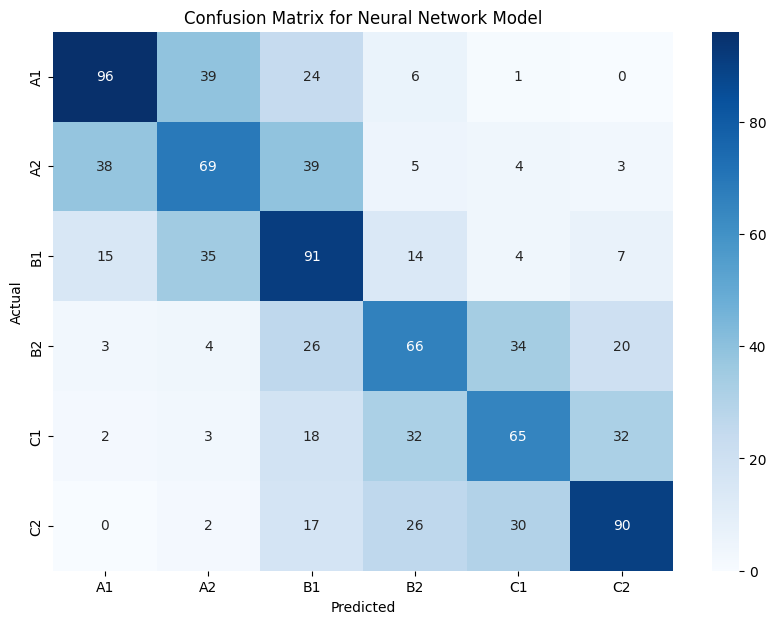

In [82]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test_actual_labels, y_pred_test_actual_labels_decoded)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Neural Network Model')
plt.show()

In [87]:
# Create a DataFrame with actual and predicted labels
results_df = pd.DataFrame({
    'Sentence': X_test_raw,  # Use the raw text data corresponding to the test set
    'Actual Label': y_test_actual_labels,
    'Predicted Label': y_pred_test_actual_labels_decoded
})

# Identify misclassified instances
misclassified_df = results_df[results_df['Actual Label'] != results_df['Predicted Label']]

# Display some examples of misclassified instances
misclassified_samples = misclassified_df.sample(n=15)  # Adjust n to show more or fewer examples
misclassified_samples

,Sentence,Actual Label,Predicted Label
4112,"Dans une clairière enneigée, entourée d'arbres...",C2,B1
2465,Des enfants en choeur : Des petits pois avec d...,A2,B1
17,"Le soir, je me cuche tôt parce que je dois êtr...",A1,A2
1231,Le paysage devient tout blanc à cause de la ne...,A1,B1
4202,L'une des plus emblématiques est Marie Sophie ...,B2,A1
3509,"Ce sera inoubliable, j'en suis sûr!",A1,A2
4728,Tu as pensé à envoyer un message d'excuses à t...,B1,A2
1101,Je suis dentiste dans un nouveau cabinet depui...,B1,A1
3929,Puis-je vous proposer un massage en attendant ...,B1,A1
2897,"On lui accorda, pour compagnes, et afin de l'a...",C2,C1


<ipython-input-88-5fdf07dae0d6>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=misclassification_rate.index, y=misclassification_rate.values, palette='viridis')


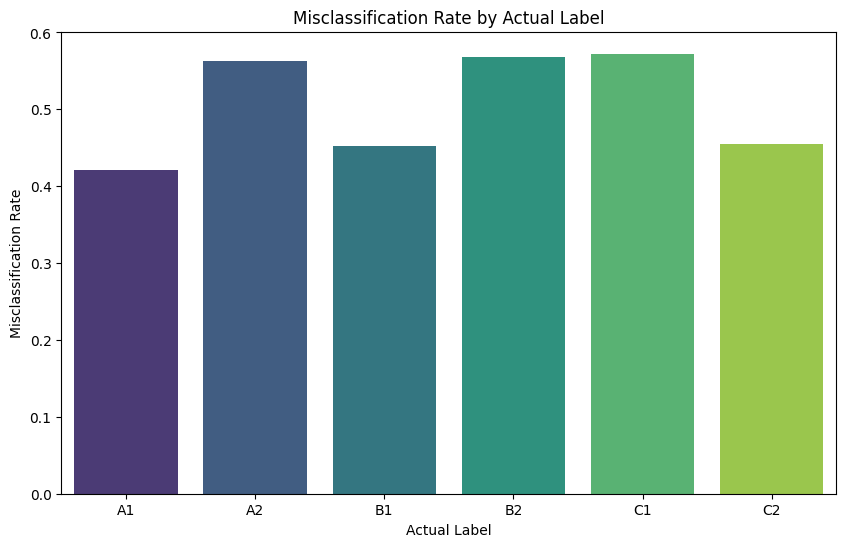

In [88]:
# Count the misclassifications for each actual label
misclassified_counts = misclassified_df['Actual Label'].value_counts().sort_index()
total_counts = results_df['Actual Label'].value_counts().sort_index()

# Calculate the proportion of misclassifications
misclassification_rate = misclassified_counts / total_counts

# Plot the misclassification rate for each class
plt.figure(figsize=(10, 6))
sns.barplot(x=misclassification_rate.index, y=misclassification_rate.values, palette='viridis')
plt.xlabel('Actual Label')
plt.ylabel('Misclassification Rate')
plt.title('Misclassification Rate by Actual Label')
plt.show()

<ipython-input-89-c6acd9247768>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified_df['Sentence Length'] = misclassified_df['Sentence'].apply(len)


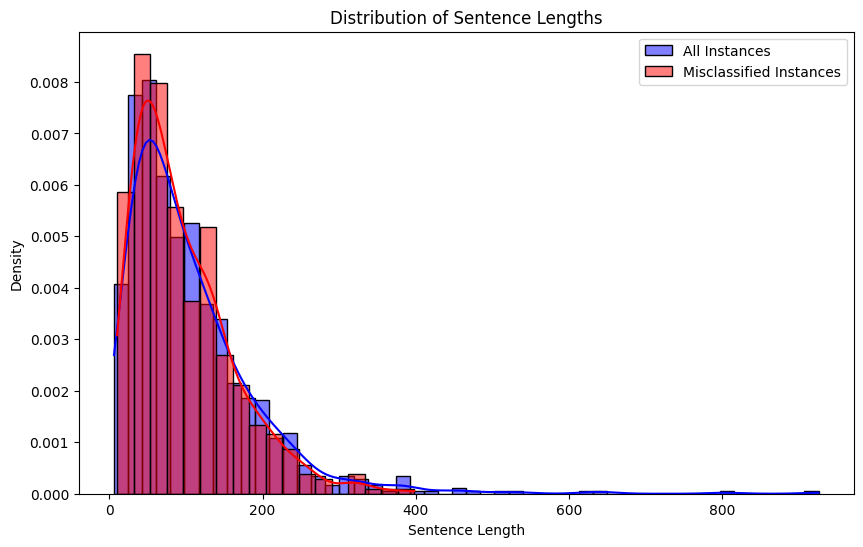

In [89]:
# Add sentence length to the DataFrame
results_df['Sentence Length'] = results_df['Sentence'].apply(len)
misclassified_df['Sentence Length'] = misclassified_df['Sentence'].apply(len)

# Plot the distribution of sentence lengths for misclassified and correctly classified instances
plt.figure(figsize=(10, 6))
sns.histplot(results_df['Sentence Length'], color='blue', label='All Instances', kde=True, stat="density")
sns.histplot(misclassified_df['Sentence Length'], color='red', label='Misclassified Instances', kde=True, stat="density")
plt.xlabel('Sentence Length')
plt.ylabel('Density')
plt.title('Distribution of Sentence Lengths')
plt.legend()
plt.show()

In [91]:
# Count the frequency of each actual-predicted pair
misclassification_patterns = misclassified_df.groupby(['Actual Label', 'Predicted Label']).size().reset_index(name='Count')
misclassification_patterns = misclassification_patterns.sort_values(by='Count', ascending=False)

# Display the most common misclassification patterns
misclassification_patterns.head(15)

,Actual Label,Predicted Label,Count
0,A1,A2,39
5,A2,B1,39
4,A2,A1,38
10,B1,A2,35
17,B2,C1,34
23,C1,C2,32
22,C1,B2,32
27,C2,C1,30
16,B2,B1,26
26,C2,B2,26
